In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
from numpy.random import seed
seed(123)
from datetime import datetime
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
#from keras import models, layers, optimizers, regularizers
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline


In [2]:
data = pd.read_csv('AirBnb-listings_final.csv')

In [3]:
#Borramos los renglones nulos completos que puedan llegar a existir
data = data.dropna(how='any', subset=['Consecutivo'])

In [4]:
amenities = pd.read_csv('amenities.csv')

In [5]:
#Columns and data frame for the Regression
data_reg = data[["Consecutivo","id","neighbourhood_b","property_type","room_type","accommodates","bathrooms","bedrooms","beds",
                "price","cleaning_fee","minimum_nights","availability_30","number_of_reviews","cancellation_policy","host_since"]]

In [6]:
# determine the number of missing entries in each column
for col in data_reg.columns:
    print (col + ', Number of Missing Values:', len(data_reg[col][data_reg[col].isnull()]))

Consecutivo, Number of Missing Values: 0
id, Number of Missing Values: 0
neighbourhood_b, Number of Missing Values: 3962
property_type, Number of Missing Values: 0
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bathrooms, Number of Missing Values: 10
bedrooms, Number of Missing Values: 10
beds, Number of Missing Values: 27
price, Number of Missing Values: 0
cleaning_fee, Number of Missing Values: 6953
minimum_nights, Number of Missing Values: 0
availability_30, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
cancellation_policy, Number of Missing Values: 1
host_since, Number of Missing Values: 62


In [7]:
# remove NaN values from dataframe from this columns because are inconsistent data
data_reg = data_reg.dropna(how='any', subset=["neighbourhood_b","bathrooms","bedrooms","beds","cancellation_policy"])

In [8]:
# determine the number of missing entries in each column for the dataframe for the regression
for col in data_reg.columns:
    print (col + ', Number of Missing Values:', len(data_reg[col][data_reg[col].isnull()]))

Consecutivo, Number of Missing Values: 0
id, Number of Missing Values: 0
neighbourhood_b, Number of Missing Values: 0
property_type, Number of Missing Values: 0
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bathrooms, Number of Missing Values: 0
bedrooms, Number of Missing Values: 0
beds, Number of Missing Values: 0
price, Number of Missing Values: 0
cleaning_fee, Number of Missing Values: 4920
minimum_nights, Number of Missing Values: 0
availability_30, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
cancellation_policy, Number of Missing Values: 0
host_since, Number of Missing Values: 54


In [9]:
complete_df = pd.merge(data_reg,
                 amenities,
                 on='id', 
                 how='left')

In [10]:
complete_df.head()

,Consecutivo,id,neighbourhood_b,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool,Internet/pocket wifi/wifi,Long_term_stays_allowed,Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s),Private_entrance,Self_check-in,Smoking_allowed,"Step-free access/wheelchair accessible, or anything containing 'accessible'",Suitable_for_events,Unnamed: 27
0,1,14714,Juarez,Apartment,Private room,2,1.0,1.0,1.0,$478.00,...,0,1,1,0,0,0,1,0,0,NaN
1,2,22787,San Rafael,Boutique hotel,Private room,2,1.0,1.0,1.0,"$1,969.00",...,0,1,0,0,0,1,0,0,0,NaN
2,5,44616,Condesa,Bed and breakfast,Private room,16,9.0,9.0,1.0,"$1,893.00",...,0,1,0,0,0,0,0,0,0,NaN
3,6,58955,Roma Norte,Loft,Entire home/apt,2,1.5,1.0,1.0,"$1,625.00",...,0,1,0,0,0,0,0,1,0,NaN
4,7,61792,Condesa,House,Private room,2,1.0,1.0,1.0,$956.00,...,0,1,0,0,0,1,0,0,0,NaN


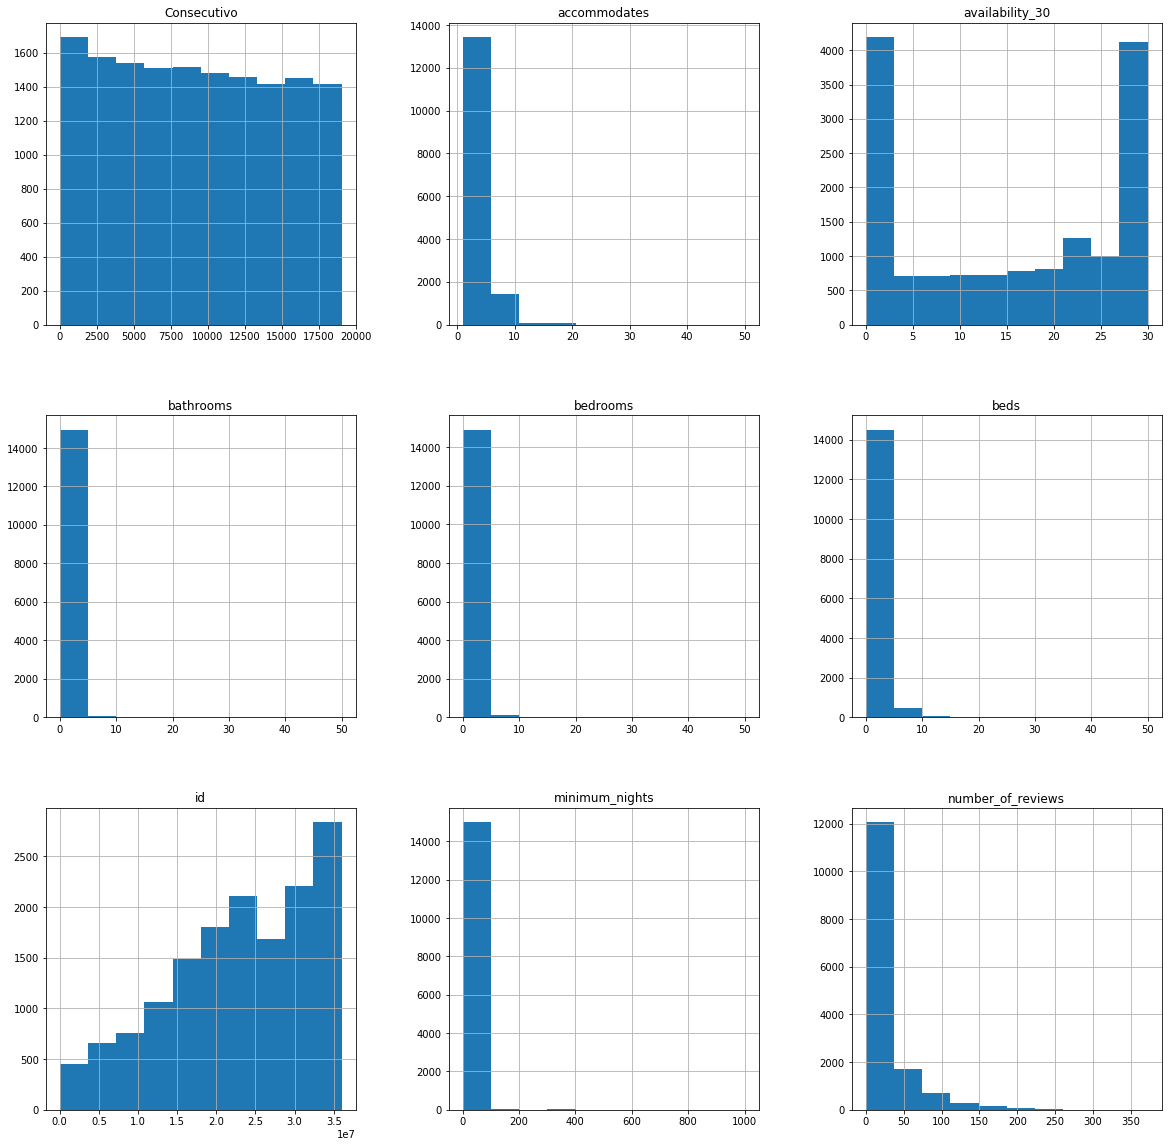

In [11]:
# Plotting the distribution of numerical and boolean categories to analyze whether features contain sufficient numbers of instances in each category to make them worth including:
data_reg.hist(figsize=(20,20));

In [12]:
# Features cleanse
# drop any inconsistent values
print ('Number of Accommodates 0:', len(complete_df[complete_df['accommodates'] == 0]))
print ('Number of Bedrooms 0:', len(complete_df[complete_df['bedrooms'] == 0]))
print ('Number of Beds 0:', len(complete_df[complete_df['beds'] == 0]))
print ('Number of Listings with Price $0.00:', len(complete_df[complete_df['price'] == 0.00]))


complete_df = complete_df[complete_df['accommodates'] != 0]
complete_df = complete_df[complete_df['bedrooms'] != 0]
complete_df = complete_df[complete_df['beds'] != 0]
complete_df = complete_df[complete_df['price'] != 0.00]

Number of Accommodates 0: 0
Number of Bedrooms 0: 507
Number of Beds 0: 92
Number of Listings with Price $0.00: 0


In [13]:
# Property type
complete_df.property_type.value_counts()

Apartment                  9639
House                      1543
Condominium                 929
Loft                        705
Serviced apartment          505
Guest suite                 261
Bed and breakfast           192
Hostel                      168
Boutique hotel              153
Guesthouse                  101
Townhouse                    71
Other                        51
Aparthotel                   31
Hotel                        31
Casa particular (Cuba)       28
Tiny house                   19
Villa                        10
Bungalow                      5
Dorm                          4
Cycladic house (Greece)       3
Chalet                        3
Dome house                    3
Cabin                         2
Castle                        1
Earth house                   1
Name: property_type, dtype: int64

In [14]:
# Some cleaning of property types is required as there are a large number of categories with only a few listings. 
# The categories 'apartment', 'house' and 'hotel' will be used as these are the most representative and all listings can by classified by this
complete_df.property_type.replace({
    'Boutique hotel':  'Hotel',
    'Hostel':  'Hotel',
    'Villa':  'House',
    'Bed and breakfast':  'Hotel',
    'Loft':  'Apartment',
    'Guesthouse':  'House',
    'Other':  'House',
    'Serviced apartment':  'Apartment',
    'Guest suite':  'Apartment',
    'Condominium':  'House',
    'Tiny house':  'House',
    'Townhouse':  'House',
    'Aparthotel':  'Hotel',
    'Bungalow':  'House',
    'Cabin':  'House',
    'Camper/RV':  'Apartment',
    'Nature lodge':  'House',
    'Chalet':  'House',
    'Cottage':  'House',
    'Farm stay':  'House',
    'Casa particular (Cuba)':  'House',
    'Resort':  'Hotel',
    'Heritage hotel (India)':  'Hotel',
    'Bus':  'House',
    'Boat':  'House',
    'Dorm':  'Apartment',
    'In-law':  'Apartment',
    'Campsite':  'Apartment',
    'Dome house':  'House',
    'Treehouse':  'House',
    'Cave':  'House',
    'Cycladic house (Greece)':  'House',
    'Earth house':  'House',
    'Barn':  'House',
    'Castle':  'House'
    }, inplace=True)

complete_df.property_type.value_counts()

Apartment    11114
House         2770
Hotel          575
Name: property_type, dtype: int64

In [15]:
# convert formatting for price and cleaning fee; now we have a string cause it has a $
complete_df['price'] = (complete_df['price'].str.replace(r'[^-+\d.]', '').astype(float))
complete_df['cleaning_fee'] = (complete_df['cleaning_fee'].str.replace(r'[^-+\d.]', '').astype(float))


In [16]:
# anytime cleaning_fee is NaN we can assume there is no cleaning fee, so we are replacing NaN with 0.0

complete_df['cleaning_fee'] = complete_df['cleaning_fee'].replace(np.nan, 0)

In [17]:
# create new column with total paid amount for analysis purposes

complete_df["total_paid_amount"] = complete_df["price"] + complete_df["cleaning_fee"]

complete_df.head()


,Consecutivo,id,neighbourhood_b,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,Internet/pocket wifi/wifi,Long_term_stays_allowed,Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s),Private_entrance,Self_check-in,Smoking_allowed,"Step-free access/wheelchair accessible, or anything containing 'accessible'",Suitable_for_events,Unnamed: 27,total_paid_amount
0,1,14714,Juarez,Apartment,Private room,2,1.0,1.0,1.0,478.0,...,1,1,0,0,0,1,0,0,NaN,765.0
1,2,22787,San Rafael,Hotel,Private room,2,1.0,1.0,1.0,1969.0,...,1,0,0,0,1,0,0,0,NaN,1969.0
2,5,44616,Condesa,Hotel,Private room,16,9.0,9.0,1.0,1893.0,...,1,0,0,0,0,0,0,0,NaN,1893.0
3,6,58955,Roma Norte,Apartment,Entire home/apt,2,1.5,1.0,1.0,1625.0,...,1,0,0,0,0,0,1,0,NaN,2103.0
4,7,61792,Condesa,House,Private room,2,1.0,1.0,1.0,956.0,...,1,0,0,0,1,0,0,0,NaN,1243.0


In [18]:
# Cancellation policy will be homologated within flexible, moderate and strict, the mot representative policies
complete_df.cancellation_policy.value_counts()

flexible                       6753
moderate                       4456
strict_14_with_grace_period    3231
super_strict_30                  13
super_strict_60                   6
Name: cancellation_policy, dtype: int64

In [19]:
complete_df.cancellation_policy.replace({
    'strict_14_with_grace_period': 'strict',
    'super_strict_30': 'strict',
    'super_strict_60': 'strict'
    }, inplace=True)

complete_df.cancellation_policy.value_counts()

flexible    6753
moderate    4456
strict      3250
Name: cancellation_policy, dtype: int64

In [20]:
# Host_since is a datetime column and we will converted into the number of days that a host has been on the platform, measured from the date that the data was scraped (24 June, 2019)

# Converting to datetime
complete_df.host_since = pd.to_datetime(complete_df.host_since) 

# Calculating the number of days
complete_df['host_days_active'] = (datetime(2019, 6, 24) - complete_df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(complete_df['host_days_active'].mean(),0))
print("Median days as host:", complete_df['host_days_active'].median())

# Replacing null values with the median
complete_df.host_days_active.fillna(complete_df.host_days_active.median(), inplace=True)

Mean days as host: 1197.0
Median days as host: 1153.0


# Exploratory Data Analysis

In [21]:
# Time Series

# How long have hosts been listing properties on Airbnb in London?

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(complete_df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(complete_df.host_since).strftime('%d %B %Y')}.")


Of the Airbnb hosts that are still listing on the site, the first joined on 04 April 2009, and the most recent joined on 21 June 2019.


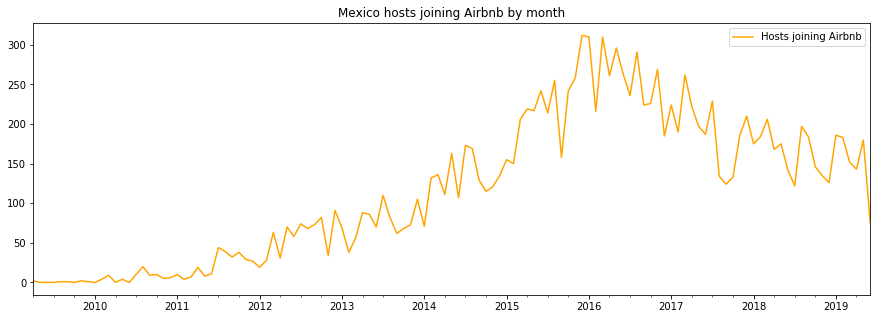

In [22]:
# Plotting host joining AirBnB by month we can see a boom during 2016

plt.figure(figsize=(15,5))
complete_df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
plt.title('Mexico hosts joining Airbnb by month')
plt.legend()
plt.xlim('2009-04-01', '2019-06-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [23]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(complete_df.set_index('host_since').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)


In [24]:
def decompose_time_series(complete_df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(complete_df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(complete_df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

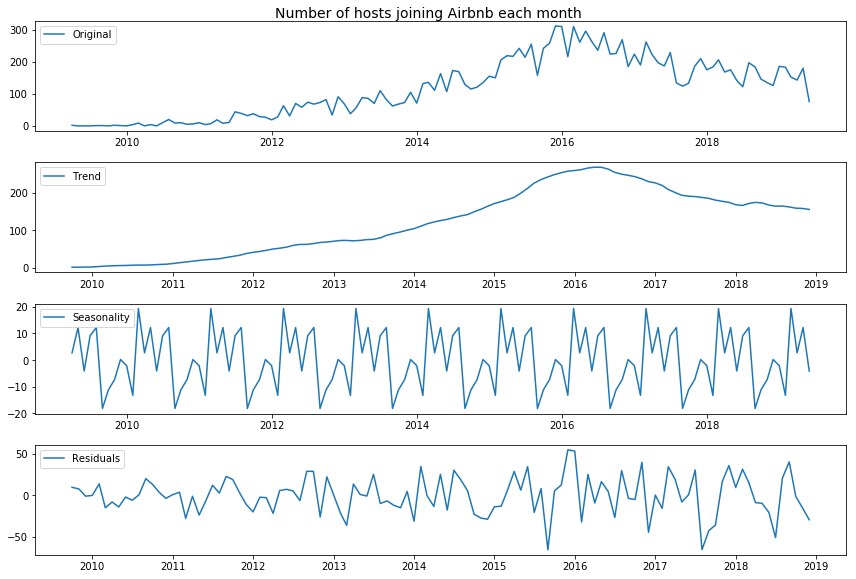

In [25]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

In [ ]:
# Numerical Features

In [26]:
round(complete_df.describe(),1)

,Consecutivo,id,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,minimum_nights,availability_30,...,Long_term_stays_allowed,Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s),Private_entrance,Self_check-in,Smoking_allowed,"Step-free access/wheelchair accessible, or anything containing 'accessible'",Suitable_for_events,Unnamed: 27,total_paid_amount,host_days_active
count,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,...,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,14459.0,0.0,14459.0,14459.0
mean,9169.0,22748149.3,3.1,1.4,1.5,1.8,1191.1,234.6,3.4,15.0,...,0.4,0.2,0.3,0.3,0.3,0.3,0.1,NaN,1425.7,1197.2
std,5513.7,9210011.2,2.2,1.1,1.1,1.7,2755.2,357.4,19.1,11.8,...,0.5,0.4,0.4,0.4,0.5,0.4,0.2,NaN,2843.4,699.2
min,1.0,14714.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,38.0,3.0
25%,4340.5,16483945.0,2.0,1.0,1.0,1.0,421.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,516.0,681.0
50%,9005.0,23494461.0,2.0,1.0,1.0,1.0,765.0,150.0,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,975.0,1153.0
75%,13881.5,30827550.0,4.0,1.5,2.0,2.0,1319.0,382.0,2.0,27.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,1682.0,1614.0
max,19030.0,36001745.0,50.0,50.0,50.0,50.0,191170.0,11470.0,1000.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,191839.0,3733.0


In [27]:
# Price

# what is the overall distribution of prices?data_reg['cleaning_fee'] = (data_reg['cleaning_fee'].str.replace(r'[^-+\d.]', '').astype(float))

print(f"Nightly advertised prices range from {min(complete_df.price)} to {max(complete_df.price)}.")

Nightly advertised prices range from 0.0 to 191170.0.


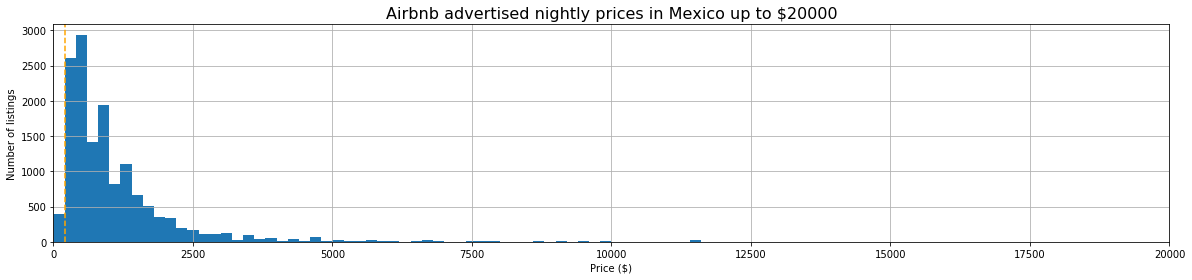

In [28]:
# Distribution of prices from $0 to $1000

plt.figure(figsize=(20,4))
complete_df.price.hist(bins=100, range=(0,20000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Mexico up to $20000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

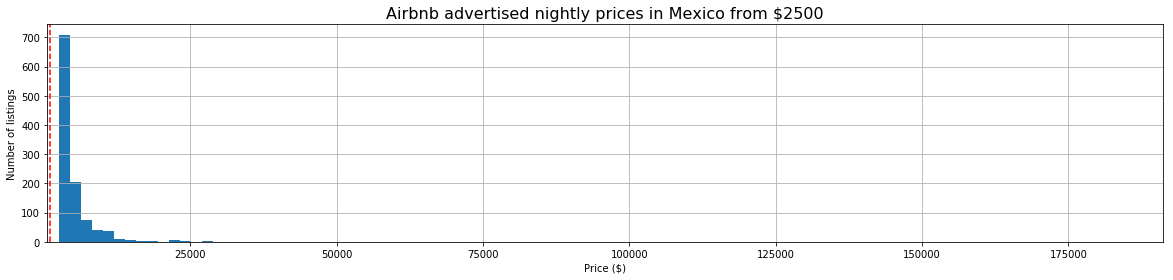

In [29]:
# Distribution of prices from 2500 upwards

plt.figure(figsize=(20,4))
complete_df.price.hist(bins=100, range=(2500, max(complete_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Mexico from $2500", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [30]:
# Replacing values under $10 with $10
#complete_df.loc[complete_df.price <= 10, 'price'] = 10

# Replacing upper outliers
complete_df.loc[complete_df.price >= 2500, 'price'] = 2500

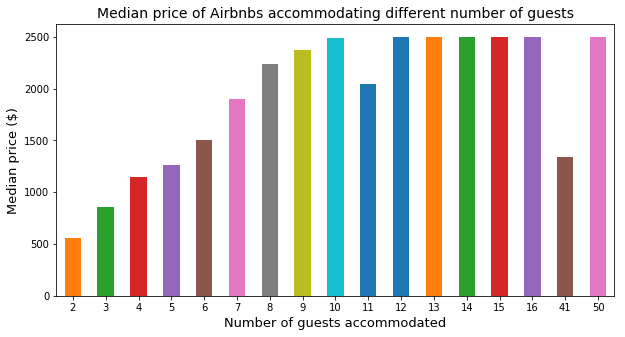

In [31]:
# Number of people accommodated, bathrooms, bedrooms and beds

plt.figure(figsize=(10,5))
complete_df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

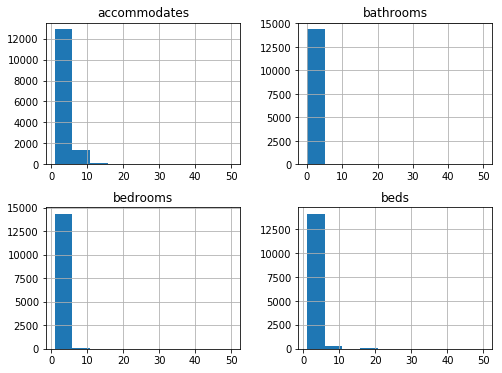

In [32]:
complete_df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [33]:
# Property and room types 

# What are the most common property and room types?

def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    complete_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

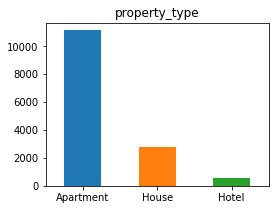

Apartment    0.768656
House        0.191576
Hotel        0.039768
Name: property_type, dtype: float64


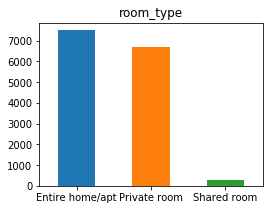

Entire home/apt    0.517740
Private room       0.463518
Shared room        0.018743
Name: room_type, dtype: float64


In [34]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(complete_df[col].value_counts(normalize=True))

C:\Users\hilda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


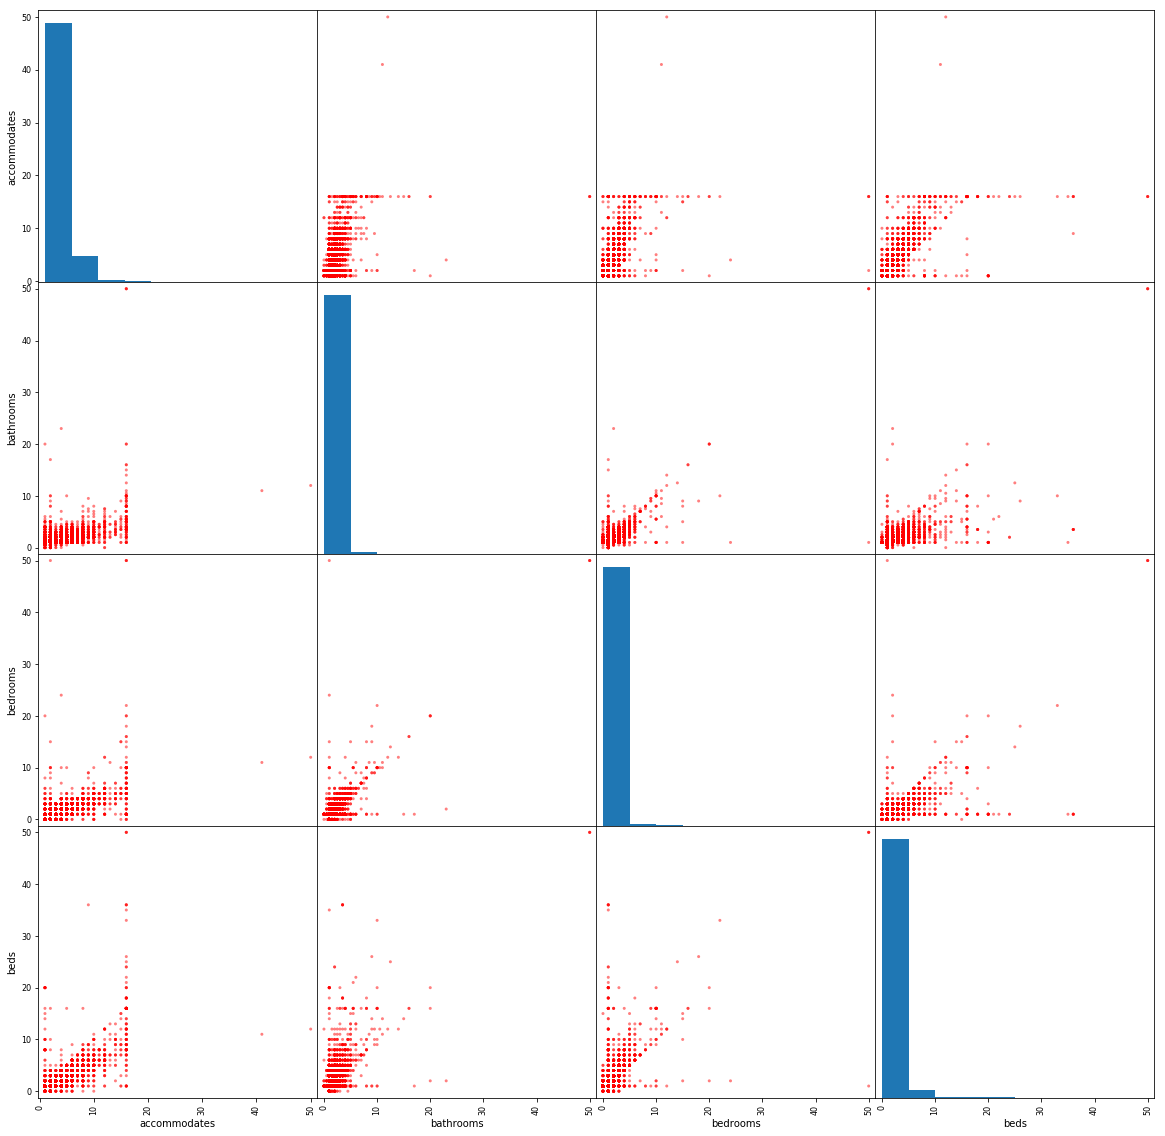

In [36]:
# check for collinearity and visualize relationship between each predictor and price
matrix_cols = ['accommodates','bathrooms','bedrooms','beds','price']
axs = pd.scatter_matrix(data[matrix_cols], figsize=(20, 20), c='red')

In [37]:
complete_df.corr()

,Consecutivo,id,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,minimum_nights,availability_30,...,Long_term_stays_allowed,Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s),Private_entrance,Self_check-in,Smoking_allowed,"Step-free access/wheelchair accessible, or anything containing 'accessible'",Suitable_for_events,Unnamed: 27,total_paid_amount,host_days_active
Consecutivo,1.000000,0.978572,0.023321,-0.013791,-0.001889,0.013796,-0.022456,-0.095572,-0.021054,0.098551,...,-0.083617,-0.078888,0.205452,-0.043966,0.018278,-0.051479,0.001112,NaN,-0.029009,-0.441931
id,0.978572,1.000000,0.023936,-0.016423,-0.001038,0.010738,-0.025969,-0.091352,-0.020495,0.086589,...,-0.059493,-0.081650,0.213657,-0.026189,0.017035,-0.040677,-0.003393,NaN,-0.027276,-0.476108
accommodates,0.023321,0.023936,1.000000,0.499857,0.638872,0.723182,0.517939,0.387325,-0.026568,-0.037157,...,0.160784,-0.005545,0.130917,0.185321,-0.079897,0.081792,-0.005591,NaN,0.289566,0.049827
bathrooms,-0.013791,-0.016423,0.499857,1.000000,0.814434,0.620016,0.304166,0.191381,0.000841,0.021875,...,0.047690,-0.004095,0.036284,0.105603,-0.026958,0.046121,0.012589,NaN,0.204855,0.037064
bedrooms,-0.001889,-0.001038,0.638872,0.814434,1.000000,0.693587,0.386585,0.241627,0.008678,-0.014912,...,0.091496,-0.007692,0.074411,0.116654,-0.043191,0.061499,0.000342,NaN,0.229858,0.036262
beds,0.013796,0.010738,0.723182,0.620016,0.693587,1.000000,0.320894,0.197370,-0.010271,0.006289,...,0.103409,-0.023100,0.063016,0.134884,-0.040071,0.071924,0.030982,NaN,0.184130,-0.012292
price,-0.022456,-0.025969,0.517939,0.304166,0.386585,0.320894,1.000000,0.334435,-0.025937,0.034645,...,0.107309,-0.021722,0.142849,0.198072,-0.164030,0.042175,-0.028432,NaN,0.456751,0.098651
cleaning_fee,-0.095572,-0.091352,0.387325,0.191381,0.241627,0.197370,0.334435,1.000000,-0.017344,-0.050465,...,0.163869,-0.035514,0.061251,0.176980,-0.109670,0.078811,-0.050767,NaN,0.305716,0.154832
minimum_nights,-0.021054,-0.020495,-0.026568,0.000841,0.008678,-0.010271,-0.025937,-0.017344,1.000000,0.030718,...,-0.028858,-0.003564,-0.026159,-0.017887,0.009145,-0.007513,0.043440,NaN,-0.008073,-0.000040
availability_30,0.098551,0.086589,-0.037157,0.021875,-0.014912,0.006289,0.034645,-0.050465,0.030718,1.000000,...,-0.053996,0.000687,0.001942,-0.041906,0.001787,-0.064467,0.030940,NaN,0.023186,-0.096132


In [38]:
# Export file as a CSV, without the Pandas index, but with the header
complete_df.to_csv("DATA_FINAL.csv", index=False, header=True)